# Seattle Airbnb Data Analysis (2016-2017)


## A Business Perspective
Over the last decade, Airbnb has taken the hotel/hospitality industry by storm and has revolutionized how people tend to make decisions in terms of shelter especially in the short term during their vacations, holidays, business trips etc. This has meant that the Airbnb business has attracted a lot of real estate investors who are hungry for better performance and revenue.
This notebook attempts to look at the Airbnb business from a host's perspective. The data that is looked at; is that of the city of Seattle for the business year starting January 2016 and ending January 2017. 

Assume one is new to the real estate business in Seattle and is looking to buy properties and list them on the Airbnb marketplace:
1. Which property type works best for which zipcode? 
For example: Entire homes might work better in a zipcode that contains familiy/friendly attractions whereas apartments might do better in a zipcode close to downtown where night life is more prominent. But how can we know for sure?
2. What makes a good host? What are preferred host performance metrics?
This second quest will basically delineate good host characteristics based on performance.
3. In Seattle, which factors overall are good for revenue?
Here, a prediction based (regression) method will be applied to model revenue. Finally, the features that dominate that model will be of interest.
The analysis that follows in the notebook attempts to best answer these questions dispassionately whilst focussing on the data.

## The Data
3 Datasets are provided. 
They are:
1.listings.csv
2.calendar.csv
3.reviews.csv
The 2 of interest for our analysis are the 'listings' and 'calendar'. Again, as stated briefly in the introduction, this notebook is taking into account the performance of the hosts of the whole business year. Therefore, a time series analysis is not going to be considered and furthermore the 'reviews' dataset is of no use to the questions posed. 
The analysis and code that now follows provides a step by step methodology to converting raw data to useful information.

In [701]:
#Importing the necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [702]:
# Create the 3 dataframes that is available for analysis
df_list = pd.read_csv('../input/seattle/listings.csv')
df_cal = pd.read_csv('../input/seattle/calendar.csv')
df_rev = pd.read_csv('../input/seattle/reviews.csv')

In [708]:
# Take a look at the features, the NaN counts and the object types to deal with
df_list.info(verbose=True)
#df_list.describe
#df_list.hist() --## A preliminary look at potentional askewness problem in the dataset
#df_list.head()
#df_cal.info(verbose=True)
#df_cal.describe
#df_cal.tail()
#df_rev.info(verbose=True)
#df_rev.describe
#df_rev.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [709]:
# Take a look at what percentage of data is null for each column in listings.csv
List_na_list=[]
for i in df_list.columns:
    List_na_list.append(df_list[i].isna().sum().sum())

ser = pd.Series(data=List_na_list, index=df_list.columns)
perc_na=lambda x: (x/len(df_list))*100
ser_perc_list=ser.apply(perc_na)
ser_perc_list[ser_perc_list>20].sort_values()

host_acceptance_rate      20.246202
host_about                22.498690
transit                   24.463070
cleaning_fee              26.977475
neighborhood_overview     27.029859
notes                     42.063908
weekly_price              47.380828
security_deposit          51.126244
monthly_price             60.267156
square_feet               97.459403
license                  100.000000
dtype: float64

In [551]:
# Take a look at what percentage of data is null for each column in calendar.csv
List_na_cal=[]
for i in df_cal.columns:
    List_na_cal.append(df_cal[i].isna().sum().sum())

ser = pd.Series(data=List_na_cal, index=df_cal.columns)
perc_na_cal=lambda x: (x/len(df_cal))*100
ser_perc_cal=ser.apply(perc_na_cal)
ser_perc_cal[ser_perc_cal>=0].sort_values()

listing_id     0.000000
date           0.000000
available      0.000000
price         32.938998
dtype: float64

### Data Wrangling Part 1
The analysis conducted above informs on the degree of data cleaning that will have to follow. 
In the listings dataset, the major observation is that features with more than 20% data missing are irrelevant to the questions that this notebook looks at, which is convenient. The 20% threshhold is impactful in determining which factors we can drop without much information loss to the analysis. The ones below that threshold can be handled on a case by case basis either through imputation or deletion.
The calendar dataset, however, poses a problem. The price is an important feature that will help build the performance metric: 'revenue' and it has 33% of its data missing. A good strategy to deal with this would be to group by each listing and imputing with the mean over each listing. The remaining empty data can still be imputed with the mean over the entire dataset since it can be inferred that for one city, one property type/price range is likely to dominate.

With this in mind, lets proceed to generating the essential performance metric feature: 'revenue'. 'revenue' will be generated looking at how much revenue each listing generated over the year. For that, each listing's booking ratio over year is multiplied by the updated daily price then multiplied by 365 to get the revenue over the year.


In [710]:
#Create a copy of calendar data frame and move to create 'revenue' feature
df_cal1=df_cal.copy()
df_cal1.head()


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [711]:
df_cal1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [712]:
# Create lambda function to mark where each listing was unavailable; meaning it was booked
change_avail= lambda x: 1 if x=="f" else 0
df_cal1['available']=df_cal1['available'].apply(change_avail)

In [713]:
# For each listing, we take the mean of all days booked over the year which yields ratio of that listing being booked
df_cal_q1_grouped_avail=df_cal1.groupby("listing_id")["available"].mean().reset_index(name ='booked_over_year')

df_cal_q1_grouped_avail

,listing_id,booked_over_year
0,3335,0.153425
1,4291,0.000000
2,5682,0.153425
3,6606,0.000000
4,7369,0.854795
...,...,...
3813,10332096,0.000000
3814,10334184,0.010959
3815,10339144,1.000000
3816,10339145,0.000000


In [714]:
#Test that above is correct
df_test=df_cal1.groupby('listing_id')['available']
#df_test.to_frame().loc['10339144']
df_test.get_group(3335).sum()/365

0.15342465753424658

In [715]:
#Group price with listing ids as well
#Replacing any missing price value with the mean of listing_id's price
#Price is not float need to fix, lambda function and manipulations to the string input to get required result
float_price= lambda x: float(x)
df_cal1['price']=df_cal1['price'].astype(str).str.replace('$', '')
df_cal1['price']=df_cal1['price'].astype(str).str.replace(',', '')
df_cal1['price']=df_cal1["price"].apply(float_price)
df_cal_q1_grouped_price=df_cal1.groupby("listing_id")["price"].mean().reset_index(name ='Average_price_year')
df_cal_q1_grouped_price

C:\Users\Dan\anaconda3\envs\py37_64\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


,listing_id,Average_price_year
0,3335,120.000000
1,4291,82.000000
2,5682,53.944984
3,6606,92.849315
4,7369,85.000000
...,...,...
3813,10332096,40.000000
3814,10334184,120.000000
3815,10339144,NaN
3816,10339145,237.904110


In [716]:
#Get a look at remaining nans
df_cal_q1_grouped_price.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   listing_id          3818 non-null   int64  
 1   Average_price_year  3723 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 59.8 KB


In [717]:
#As discussed earlier, impute remaining NaNs with the mean 
df_cal_q1_grouped_price['Average_price_year']=df_cal_q1_grouped_price['Average_price_year'].fillna(df_cal_q1_grouped_price['Average_price_year'].mean())
df_cal_q1_grouped_price.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   listing_id          3818 non-null   int64  
 1   Average_price_year  3818 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 59.8 KB


In [718]:
#Create performance metric :revenue
df1=df_cal_q1_grouped_avail['booked_over_year']
df2=df_cal_q1_grouped_price['Average_price_year']
df_cal_q1_grouped_avail['revenue']=df1*df2*365


In [719]:
#Drop booked over year column so we can merge with the listings dataframe
df_cal_q1_grouped_avail=df_cal_q1_grouped_avail.drop(columns='booked_over_year')
df_cal_q1_grouped_avail

,listing_id,revenue
0,3335,6720.000000
1,4291,0.000000
2,5682,3020.919094
3,6606,0.000000
4,7369,26520.000000
...,...,...
3813,10332096,0.000000
3814,10334184,480.000000
3815,10339144,49553.881956
3816,10339145,0.000000


In [720]:
#Merge everything using pd.merge and merge key 'listing_id'

df_list_cal=df_cal_q1_grouped_avail

df_list_cal=df_list_cal.rename(columns={"listing_id": "id"})

df_list_cal=pd.merge(df_list,df_list_cal,on='id')
df_list_cal.shape

(3818, 93)

In [721]:
#We move on to treating the nans
List_na_list=[]
for i in df_list_cal.columns:
    List_na_list.append(df_list_cal[i].isna().sum().sum())

ser1 = pd.Series(data=List_na_list, index=df_list_cal.columns)
perc_na=lambda x: (x/len(df_list))*100
ser_perc_list_cal=ser1.apply(perc_na)
ser_perc_list_cal[ser_perc_list_cal>20].sort_values()

host_acceptance_rate      20.246202
host_about                22.498690
transit                   24.463070
cleaning_fee              26.977475
neighborhood_overview     27.029859
notes                     42.063908
weekly_price              47.380828
security_deposit          51.126244
monthly_price             60.267156
square_feet               97.459403
license                  100.000000
dtype: float64

In [722]:
#first pass cleaning: drop columns where %na is greater than 20% (as we can see they are not relevant to the business questions and analysis anyways).
# See discussion about threshold in Data Wrangling part 1
df_list_cal=df_list_cal.drop(*[ser_perc_list_cal[ser_perc_list_cal>20].index],axis=1)
df_list_cal.shape


(3818, 82)

In [723]:
#Checking that required columns were removed
List_na_list=[]
for i in df_list_cal.columns:
    List_na_list.append(df_list_cal[i].isna().sum().sum())

ser1 = pd.Series(data=List_na_list, index=df_list_cal.columns)
perc_na=lambda x: (x/len(df_list))*100
ser_perc_list_cal=ser1.apply(perc_na)
ser_perc_list_cal[ser_perc_list_cal>=0].sort_values()

id                            0.000000
market                        0.000000
smart_location                0.000000
country_code                  0.000000
country                       0.000000
                               ...    
review_scores_cleanliness    17.103195
review_scores_location       17.155579
review_scores_value          17.181771
review_scores_checkin        17.234154
review_scores_accuracy       17.234154
Length: 82, dtype: float64

### Data Wrangling Part 2
The performance metric 'revenue' has been successfully added.Lets move to clean the dataset further. From the business perspective's discussion and questions posed, one can ascertain that certain features bring no value to the analysis. Obvious ones are the various urls, description of the listing, host name etc... Moreover, since the outlook of the notebook is the year as a whole and zipcodes of interest, other features such as calendar updates, scrapes, availability ranges and location data other than zipcode are unimportant. As such, below is a list of those useless features that are to be dropped.
It is noteworthy that some of these features are deemed 'useless' based on the specific analysis explained earlier. The list is generated by eye on a case by case basis. If the questions to be answered were different, this list would be different.

In [727]:
#Further inspection leads us to remove columns that are not useful to our analysis.
List_of_useless_features=['calendar_last_scraped','calendar_updated','availability_365','availability_90','availability_60','availability_30','has_availability','country_code','jurisdiction_names','market','latitude','longitude','country','smart_location','state','city','neighbourhood_group_cleansed','neighbourhood_cleansed','neighbourhood','street','host_neighbourhood','host_location','host_id','host_url','picture_url','experiences_offered','listing_url', 'scrape_id', 'last_scraped', 'name', 'description','host_name','host_thumbnail_url','host_picture_url','summary','thumbnail_url','xl_picture_url','medium_url','space','first_review','last_review']
df_list_cal1=df_list_cal.drop(List_of_useless_features,axis=1)


### Evaluation Part 1: Which property type works best for which zipcode?
As discussed earlier, this question looks at the data from a host's perspective. Where and how to invest in Seattle? 
The dataset is ready to answer this first question. Notice that zipcode is needed as an categorical object so it can be grouped by and analyzed upon. Later analysis in the notebook will require it be converted to a dummy variable in order to fit in the regressor model.


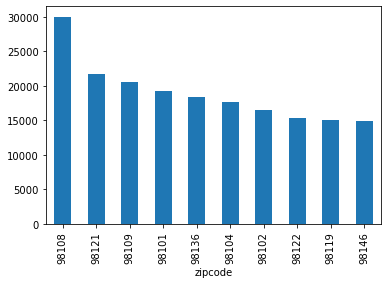

In [573]:
'''Will work on zipcode, propertytype and our performance metric available_over_year
Notice that we do not need get_dummies yet'''
df_question1=df_list_cal1.groupby(['property_type','zipcode'],sort=True)['revenue'].mean()
df_question1['Apartment']
df_question1['Apartment'].nlargest(10).plot(kind='bar'); #Initial check to see if results make sense


In [728]:
#Get unique values of property types to plot
set_of_property_types=[]
for i in range(int(len(df_question1))):    
    set_of_property_types.append(df_question1.index[i][0])
set_of_property_types=set(set_of_property_types)

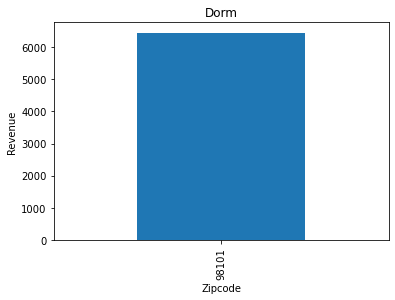

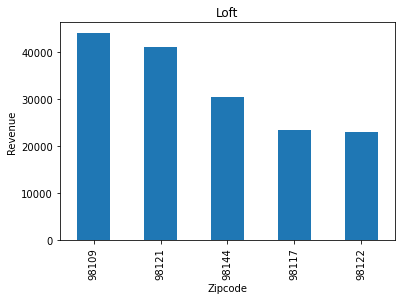

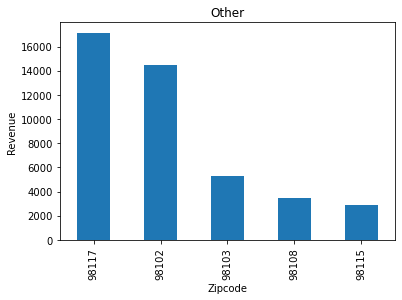

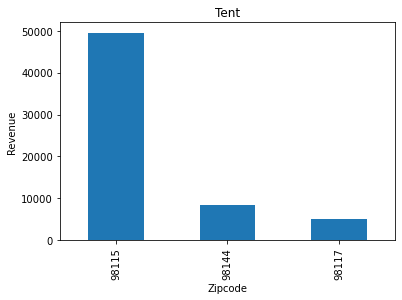

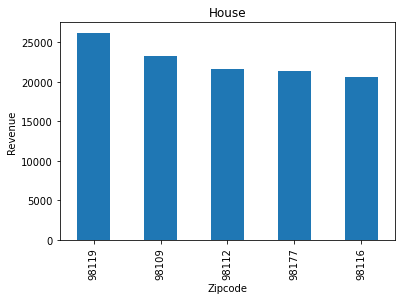

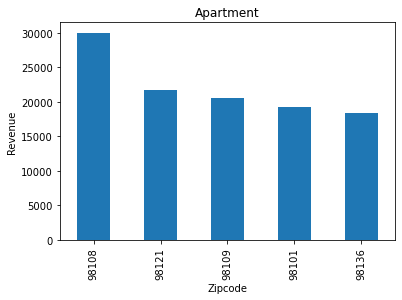

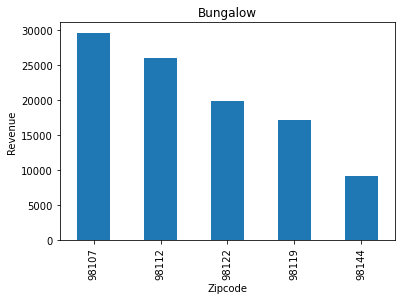

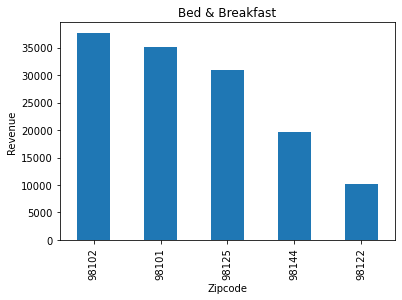

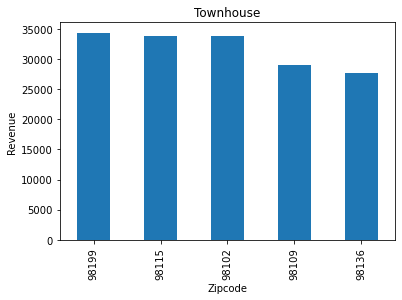

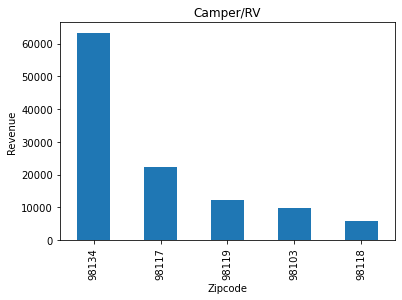

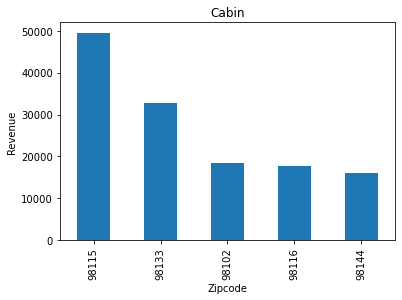

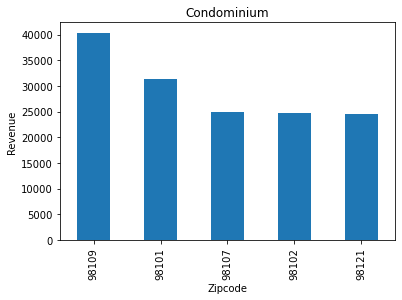

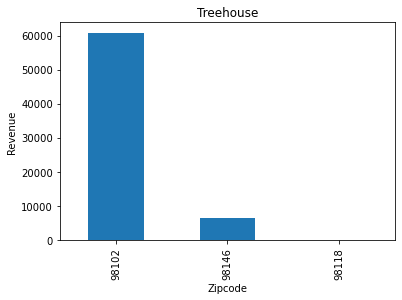

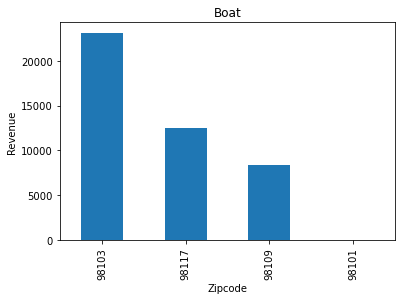

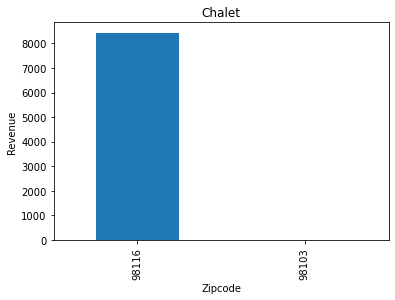

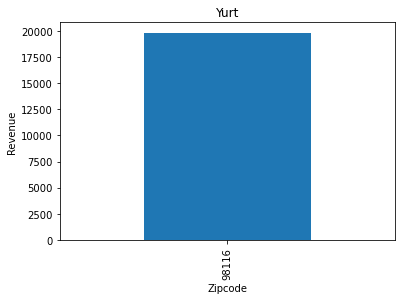

In [735]:
'''Graphical presentation for question1'''
for e in set_of_property_types:
    df_question1[e].nlargest(5).plot(kind='bar')
    plt.title(e)
    plt.xlabel('Zipcode')
    plt.ylabel('Revenue')
    plt.show() 

In [734]:
for e in set_of_property_types:
    print(e,df_question1[e].nlargest(5))
   

Dorm zipcode
98101    6444.880535
Name: revenue, dtype: float64
Loft zipcode
98109    44119.529412
98121    41085.412760
98144    30379.466165
98117    23417.879195
98122    23094.957515
Name: revenue, dtype: float64
Other zipcode
98117    17131.616766
98102    14467.000000
98103     5248.401515
98108     3504.054532
98115     2851.717044
Name: revenue, dtype: float64
Tent zipcode
98115    49553.881956
98144     8320.000000
98117     5050.000000
Name: revenue, dtype: float64
House zipcode
98119    26221.843177
98109    23304.444810
98112    21680.180791
98177    21441.283314
98116    20642.562027
Name: revenue, dtype: float64
Apartment zipcode
98108    30015.636364
98121    21699.246545
98109    20536.370449
98101    19328.095358
98136    18343.329743
Name: revenue, dtype: float64
Bungalow zipcode
98107    29580.000000
98112    25979.375000
98122    19810.000000
98119    17091.560734
98144     9135.000000
Name: revenue, dtype: float64
Bed & Breakfast zipcode
98102    37695.857143
98101

### Evaluation Discussion Part 1: Which property type works best for which zipcode?
From the generated bar plots and summary of results above:
1. Camper/RVs are very popular in the 98134 zipcode generating almost north of 63,000 USD on average.
2. For popular property types such as apartments, bed/breakfast, townhouses, houses, condomimiums and lofts, in good performing zipcodes (as shown above); the average generated revenue is in the 30,000 USD to 45,000 USD range.
2. For top 5 performing zipcodes for each property type, consult the generated plots above.

### Data Wrangling Part 3
Lets get to the final part of our analysis. For that purpose, 
1. the categorical variables will be converted to dummy variables and assigned 0s and 1s using the get_dummy utility of pandas. For most of the categorical variables, this method will work splendidly. There are, however, some variables that will require more meticulous processing.
2. 'host_since' feature needs to be converted to years as a float object.
3. 'amenities' and 'host_verification' features are in list forms. So applying the get_dummy method directly will yield useless information. These 2 will need to be dealt with by extracting each unique value and assigning each to a column and then indexing where each occur for each listing. 
The cells below deal with all of that.

In [737]:
"Dealing with all categorical features labelled as either t or f (yes or no)"
df_final_1=df_list_cal1.copy()
list_of_true_false=['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','requires_license','instant_bookable','require_guest_profile_picture','require_guest_phone_verification']

deal_true_false=lambda x:  int(1) if x=='t' else (int(0) if x=='f' else x)
for p in list_of_true_false:
    df_final_1[p]=df_final_1[p].apply(deal_true_false)
    #print(df_final_1[p].head(5))
    #input()

    


In [738]:
'''Deal with nans in the subset of categoricals we just dealt with'''
df_final_1[list_of_true_false].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_is_superhost                 3816 non-null   float64
 1   host_has_profile_pic              3816 non-null   float64
 2   host_identity_verified            3816 non-null   float64
 3   is_location_exact                 3818 non-null   int64  
 4   requires_license                  3818 non-null   int64  
 5   instant_bookable                  3818 non-null   int64  
 6   require_guest_profile_picture     3818 non-null   int64  
 7   require_guest_phone_verification  3818 non-null   int64  
dtypes: float64(3), int64(5)
memory usage: 268.5 KB


In [739]:
"Almost no missing data so for the few cases replace nan with mode; this imputation method seems best given the characteristic of those features"
for w in list_of_true_false:
    df_final_1[w]=df_final_1[w].fillna(df_final_1[w].mode()[0])
#df_final_1[list_of_true_false].info(verbose=True)
#df_final_1.info(verbose=True)

In [790]:
'''Deal with host_response_rate, price and extra_people. We need to convert those to float'''
df_final_2=df_final_1.copy()
list_of_price=['host_response_rate','price','extra_people']
float_price= lambda x: float(re.sub('[^0-9.]','',x)) if pd.isna(x)==False else (np.nan)
for q in list_of_price:
    df_final_2[q]=df_final_2[q].apply(float_price)

'Deal with nan'    
df_final_2[list_of_price].info()
df_final_2['host_response_rate']=df_final_2['host_response_rate'].fillna(df_final_2['host_response_rate'].mean())

df_final_2[list_of_price].info()






<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   host_response_rate  3295 non-null   float64
 1   price               3818 non-null   float64
 2   extra_people        3818 non-null   float64
dtypes: float64(3)
memory usage: 119.3 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   host_response_rate  3818 non-null   float64
 1   price               3818 non-null   float64
 2   extra_people        3818 non-null   float64
dtypes: float64(3)
memory usage: 119.3 KB


In [791]:
'Deal with host_since need to convert to years'
reference_last_day=pd.to_datetime('2017-01-02')
df_final_2['host_since']=(reference_last_day-pd.to_datetime(df_final_2['host_since'])).dt.days/365

df_final_2['host_since'].describe()


count    3816.000000
mean        3.291161
std         1.561083
min         1.000000
25%         1.969863
50%         3.058904
75%         4.380822
max         8.150685
Name: host_since, dtype: float64

In [792]:
'Fill nans with average'
#print(df_final_2['host_since'].describe())
df_final_2['host_since']=df_final_2['host_since'].fillna(df_final_2['host_since'].mean())
df_final_2['host_since'].describe()

count    3818.000000
mean        3.291161
std         1.560673
min         1.000000
25%         1.969863
50%         3.060274
75%         4.380822
max         8.150685
Name: host_since, dtype: float64

In [793]:
'''Deal with other categoricals using get dummies'''
df_final_3=df_final_2.copy()
"Look at the unique values one by one"
list_of_categoricals=df_final_3.select_dtypes(include='object').columns
print(list_of_categoricals)
#df_final_3['host_verifications'].unique()

Index(['host_response_time', 'host_verifications', 'zipcode', 'property_type',
       'room_type', 'bed_type', 'amenities', 'cancellation_policy'],
      dtype='object')


In [794]:
'''We see we have problems with host_verifications and amenities since we cannot pass a them through a simple get_dummies
function. The rest is fine'''
#We create the list of those that are ready for the get dummy function
cat_cols=['host_response_time', 'zipcode', 'property_type',
       'room_type', 'bed_type', 'cancellation_policy']

In [795]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in cat_cols:
        try:
            df=pd.concat([df.drop(col,axis=1),pd.get_dummies(df[col],prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)],axis=1)
        except:
            continue

    return df

In [796]:
'''Set dummy_na to false since the nans are of no value'''
df_final_3=create_dummy_df(df_final_3, cat_cols, dummy_na=False)

In [797]:
'''We can finally deal with the complications  host_verifications and amenities '''
df_final_4=df_final_3.copy()
df_final_4.info(verbose=True) #check if everything worked ok

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 88 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     3818 non-null   int64  
 1   host_since                             3818 non-null   float64
 2   host_response_rate                     3818 non-null   float64
 3   host_is_superhost                      3818 non-null   float64
 4   host_listings_count                    3816 non-null   float64
 5   host_total_listings_count              3816 non-null   float64
 6   host_verifications                     3818 non-null   object 
 7   host_has_profile_pic                   3818 non-null   float64
 8   host_identity_verified                 3818 non-null   float64
 9   is_location_exact                      3818 non-null   int64  
 10  accommodates                           3818 non-null   int64  
 11  bath

In [798]:
'''Take a look at amenities data type'''
df_final_4["amenities"].unique()

array(['{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}',
       '{TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials}',
       '{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,"Free Parking on Premises","Pets Allowed","Pets live on this property",Dog(s),Cat(s),"Hot Tub","Indoor Fireplace",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector",Essentials,Shampoo}',
       ...,
       '{"Cable TV","Wireless Internet",Kitchen,"Free Parking on Premises",Breakfast,"Pets live on this property",Dog(s),Cat(s),Heating,Washer,Dryer,"Smoke Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials,Hangers,"Hair Dryer",Iron,"Laptop Friendly Workspace"}',
       '{TV,"Wireless I

In [799]:
#Try method of cleaning and extracting features of interest
df_final_4["amenities"][0].replace('"','').replace('{','').replace('}','').split(",")

['TV',
 'Cable TV',
 'Internet',
 'Wireless Internet',
 'Air Conditioning',
 'Kitchen',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer']

In [800]:
#Extract unique amenities list from amenities and apply previous method
ame=list()
for x in range(int(len(df_final_4["amenities"]))):
   ame.extend(df_final_4["amenities"][x].replace('"','').replace('{','').replace('}','').split(","))
#print(ame)
unique_ame=pd.unique(ame)
print(unique_ame)

['TV' 'Cable TV' 'Internet' 'Wireless Internet' 'Air Conditioning'
 'Kitchen' 'Heating' 'Family/Kid Friendly' 'Washer' 'Dryer'
 'Free Parking on Premises' 'Buzzer/Wireless Intercom' 'Smoke Detector'
 'Carbon Monoxide Detector' 'First Aid Kit' 'Safety Card'
 'Fire Extinguisher' 'Essentials' 'Pets Allowed'
 'Pets live on this property' 'Dog(s)' 'Cat(s)' 'Hot Tub'
 'Indoor Fireplace' 'Shampoo' 'Breakfast' '24-Hour Check-in' 'Hangers'
 'Hair Dryer' 'Iron' 'Laptop Friendly Workspace' 'Suitable for Events'
 'Elevator in Building' 'Lock on Bedroom Door' 'Wheelchair Accessible'
 'Gym' '' 'Pool' 'Smoking Allowed' 'Other pet(s)' 'Doorman'
 'Washer / Dryer']


In [801]:
#Create a matrix and dummy dataframe to be filled
dummy_m=np.zeros((len(df_final_4),len(unique_ame)))
dummy_df_amenities=pd.DataFrame(dummy_m,columns=unique_ame)
#print(dummy_df_amenities.columns)
#Fill the matrix using get_indexer based on the columns where they occur with respect to each listing
for j,k in enumerate(df_final_4["amenities"]):
    index=dummy_df_amenities.columns.get_indexer(k.replace('"','').replace('{','').replace('}','').split(","))
    dummy_df_amenities.iloc[j,index]=1


In [802]:
#We get:
dummy_df_amenities

,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Family/Kid Friendly,Washer,Dryer,...,Elevator in Building,Lock on Bedroom Door,Wheelchair Accessible,Gym,,Pool,Smoking Allowed,Other pet(s),Doorman,Washer / Dryer
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3814,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3815,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3816,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [803]:
'''Same process for host_verifications'''
df_final_4["host_verifications"].unique()[0]

"['email', 'phone', 'reviews', 'kba']"

In [804]:
verf=list()
for x in range(int(len(df_final_4["host_verifications"]))):
   verf.extend(df_final_4["host_verifications"][x].replace("'","").replace('"','').replace('[','').replace(']','').split(","))
#print(ame)
unique_verf=pd.unique(verf)
print(unique_verf)

['email' ' phone' ' reviews' ' kba' ' facebook' ' linkedin' ' jumio'
 ' google' 'phone' ' manual_offline' ' amex' ' manual_online' ' sent_id'
 ' photographer' '' 'None' ' weibo' 'google' 'reviews']


In [805]:
#Create dummy matrix and Dataframe to be filled for the verifications
dummy_verf=np.zeros((len(df_final_4),len(unique_verf)))
dummy_verf_df=pd.DataFrame(dummy_verf, columns=unique_verf)


In [806]:
for j,k in enumerate(df_final_4["host_verifications"]):
    index=dummy_verf_df.columns.get_indexer(k.replace("'","").replace('"','').replace('[','').replace(']','').split(","))
    dummy_verf_df.iloc[j,index]=1
dummy_verf_df

,email,phone,reviews,kba,facebook,linkedin,jumio,google,phone,manual_offline,amex,manual_online,sent_id,photographer,,None,weibo,google,reviews
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3814,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3816,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [807]:
#Finally we can generate our final dataframe for analysis
df_5=pd.concat([df_final_4,dummy_df_amenities,dummy_verf_df], axis=1)

In [808]:
#We drop amenities and host_verfication columns
df_5=df_5.drop(columns=['amenities','host_verifications',''])


In [809]:
#Check if all ok
df_5.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 145 columns):
 #    Column                                 Dtype  
---   ------                                 -----  
 0    id                                     int64  
 1    host_since                             float64
 2    host_response_rate                     float64
 3    host_is_superhost                      float64
 4    host_listings_count                    float64
 5    host_total_listings_count              float64
 6    host_has_profile_pic                   float64
 7    host_identity_verified                 float64
 8    is_location_exact                      int64  
 9    accommodates                           int64  
 10   bathrooms                              float64
 11   bedrooms                               float64
 12   beds                                   float64
 13   price                                  float64
 14   guests_included                       

In [811]:
#Deal with the rest of the nans
#print(df_5.isna())
nan_col=[]
for column in df_5.columns:
    if (df_5[column].isna().sum()>0):
        nan_col.append(column)
print(nan_col)   
#df_5.info(verbose=True)

['host_listings_count', 'host_total_listings_count', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']


In [812]:
'''Replace all nas with mean since given list of nan_col it seems appropriate that a certain property type with x number of 
rooms will dominate, same can be assumed for the listings count and reviews etc..
'''
for col in nan_col:
    df_5[col]=df_5[col].fillna(df_5[col].mean())

In [813]:
#Check for nans
check_col=[]
for column in df_5.columns:
    if (df_5[column].isna().sum()>0):
        check_col.append(column)
print(check_col)

[]


### Evaluation Part 2: What makes a good host? What are preferred host performance metrics?
The analysis can now focus on preferred host attributes using revenue as a basis. First a list of host characteristics is chosen manually and the analysis is conducted on that subset. Manual selection is a necessary here, because if we are to guide someone new to the Airbnb business, we need to be able to choose the behavioral traits (choices) that maximize performance.
The following are steps into conducting that analysis:


In [814]:
'''We can look into a list features that defines a host'''
list_of_host_features=[1,2,3,4,5,6,7,8,14,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,84,85,32]
sub_df5=df_5.iloc[:,list_of_host_features]
sub_df5.info(verbose=True) #check to see we have what we need

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   host_since                             3818 non-null   float64
 1   host_response_rate                     3818 non-null   float64
 2   host_is_superhost                      3818 non-null   float64
 3   host_listings_count                    3818 non-null   float64
 4   host_total_listings_count              3818 non-null   float64
 5   host_has_profile_pic                   3818 non-null   float64
 6   host_identity_verified                 3818 non-null   float64
 7   is_location_exact                      3818 non-null   int64  
 8   guests_included                        3818 non-null   int64  
 9   number_of_reviews                      3818 non-null   int64  
 10  review_scores_rating                   3818 non-null   float64
 11  revi

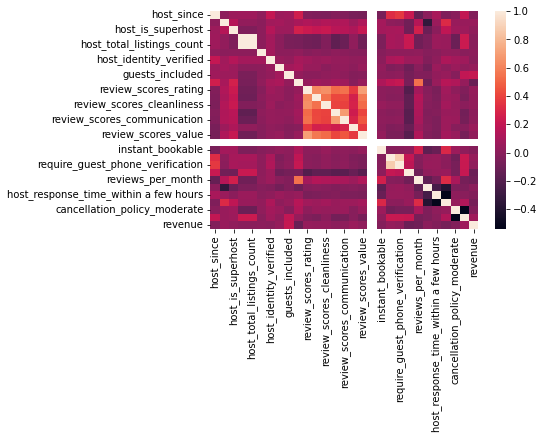

In [815]:
sns.heatmap(sub_df5.corr()); #preliminary correlation map

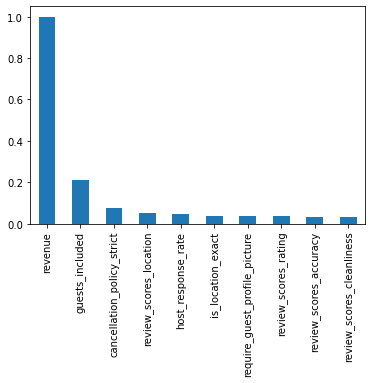

In [816]:
sub_df5.corr()['revenue'].sort_values(ascending=False).nlargest(10).plot.bar(); #generate barplot

In [817]:
"What affects performance?"
sub_df5.corr()['revenue'].nlargest(15).sort_values(ascending=False)

revenue                             1.000000
guests_included                     0.209958
cancellation_policy_strict          0.073499
review_scores_location              0.052195
host_response_rate                  0.046668
is_location_exact                   0.039414
require_guest_profile_picture       0.038381
review_scores_rating                0.038213
review_scores_accuracy              0.032379
review_scores_cleanliness           0.029876
review_scores_value                 0.021211
host_is_superhost                   0.019433
require_guest_phone_verification    0.017617
review_scores_communication         0.012365
host_has_profile_pic                0.007597
Name: revenue, dtype: float64

In [818]:
#Since review scores is important, what gets you a high review scores value
sub_df5.corr()['review_scores_rating'].nlargest(15).sort_values(ascending=False)

review_scores_rating                 1.000000
review_scores_value                  0.694942
review_scores_cleanliness            0.641622
review_scores_accuracy               0.619315
review_scores_communication          0.540032
review_scores_checkin                0.520164
review_scores_location               0.367621
host_is_superhost                    0.231712
host_response_rate                   0.130052
reviews_per_month                    0.087062
host_response_time_within an hour    0.080565
host_identity_verified               0.072179
is_location_exact                    0.041650
revenue                              0.038213
number_of_reviews                    0.034939
Name: review_scores_rating, dtype: float64

In [819]:
"What amenities are important? Generate a list of amenities"
list_of_amenities_features=list(x for x in range(86,127))
list_of_amenities_features.append(32)

sub_df6=df_5.iloc[:,list_of_amenities_features]
sub_df6.info(verbose=True) #check if we get correct dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   TV                          3818 non-null   float64
 1   Cable TV                    3818 non-null   float64
 2   Internet                    3818 non-null   float64
 3   Wireless Internet           3818 non-null   float64
 4   Air Conditioning            3818 non-null   float64
 5   Kitchen                     3818 non-null   float64
 6   Heating                     3818 non-null   float64
 7   Family/Kid Friendly         3818 non-null   float64
 8   Washer                      3818 non-null   float64
 9   Dryer                       3818 non-null   float64
 10  Free Parking on Premises    3818 non-null   float64
 11  Buzzer/Wireless Intercom    3818 non-null   float64
 12  Smoke Detector              3818 non-null   float64
 13  Carbon Monoxide Detector    3818 

In [820]:
sub_df6.corr()['revenue'].sort_values(ascending=False).nlargest(15)#.plot.bar()

revenue                     1.000000
Family/Kid Friendly         0.137876
TV                          0.137769
Elevator in Building        0.105880
Kitchen                     0.095598
Dryer                       0.094122
Safety Card                 0.092231
Gym                         0.091104
Wheelchair Accessible       0.090787
Washer                      0.087929
Doorman                     0.084639
Carbon Monoxide Detector    0.080223
Internet                    0.075253
Smoke Detector              0.072647
Air Conditioning            0.067395
Name: revenue, dtype: float64

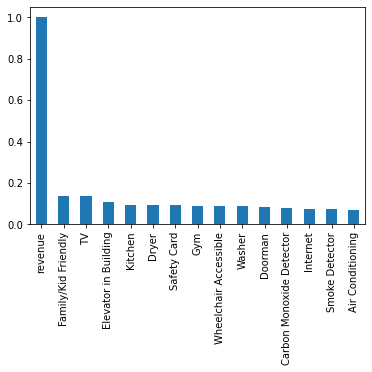

In [821]:
sub_df6.corr()['revenue'].sort_values(ascending=False).nlargest(15).plot.bar();

### Evaluation Discussion Part 2: What makes a good host? What are preferred host performance metrics?
Here are the main take aways from the analysis conducted above:
1. A rough correlation heat map showed that all review scores are closely correlated to each other. Further, we saw that revenue was poorly correlated (low coefficients) to our metrics of interest. This is exactly as expected because, it has to be underlined here that we are looking at revenue irrespective of property type and accomodation metrics. However, albeit the low correlation, we can still glean some useful information as explained below.
2. As a host: having a strict cancellation policy; having good review scores; a quick response rate; stating the location of your lisiting with precision; having guests included in your prices seem to correlate well with revenue.
3. We saw that good review scores were a must and we can further analyze that aspects such as cleanliness, good comunication, quick responses and being a superhost correlates very well with high review scores.
4. In terms of amenities to provide, being family friendly, having a TV, elevator in buildings, kitchen and dryer seem to be must have for better revenue.


### Data Wrangling Part 4:
The dataset is almost ready to be fitted to a regressor. Before that, we need to get rid of remaining columns that contain no information (askew). These can be revealed by the .describe(),.skew() or simply by plotting histograms. 'id' and 'none' need to be dropped for obvious reasons.

id


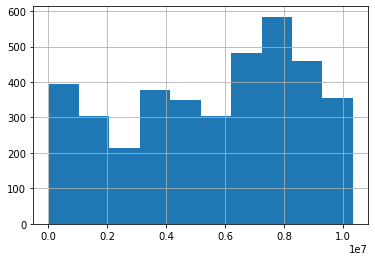


host_since


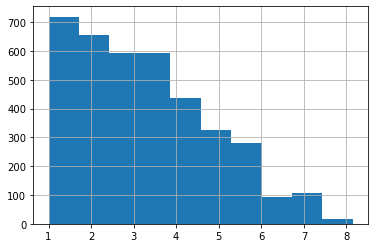


host_response_rate


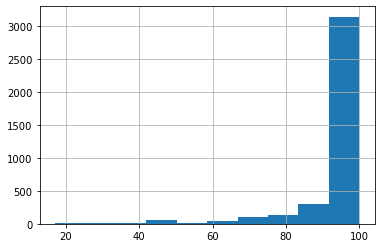


host_is_superhost


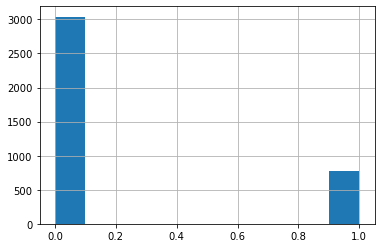


host_listings_count


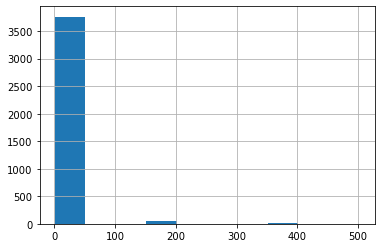


host_total_listings_count


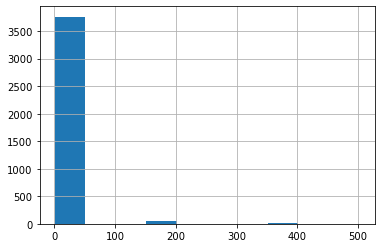


host_has_profile_pic


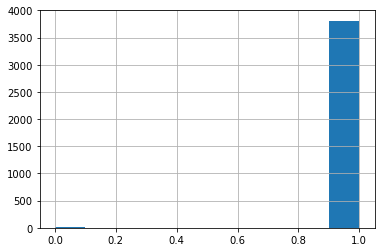


host_identity_verified


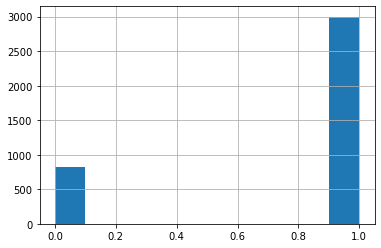


is_location_exact


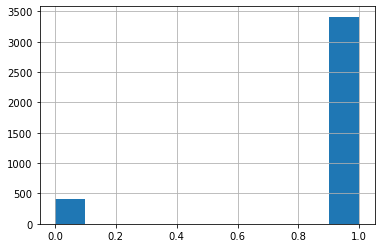


accommodates


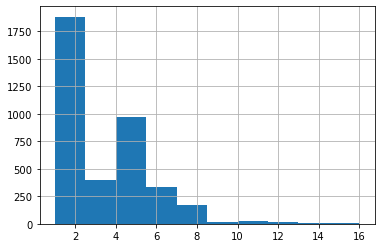


bathrooms


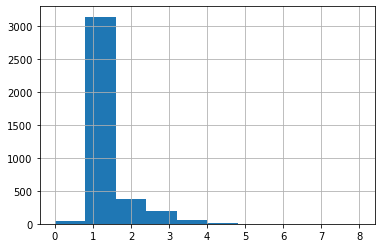


bedrooms


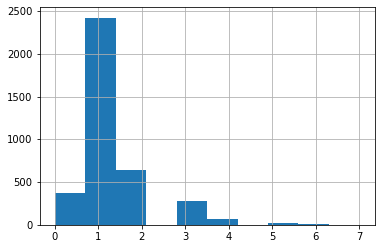


beds


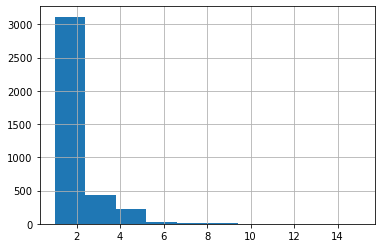


price


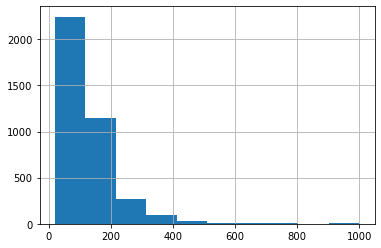


guests_included


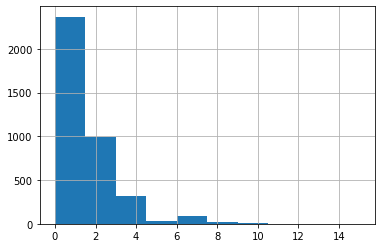


extra_people


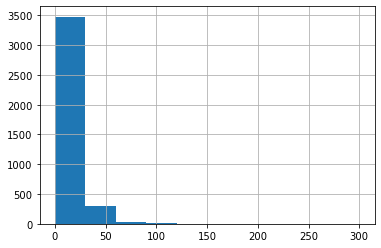


minimum_nights


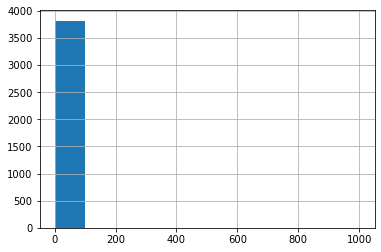


maximum_nights


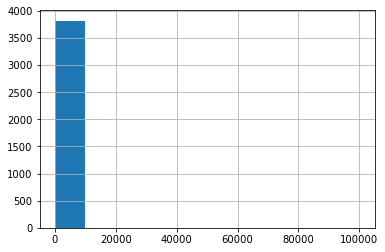


number_of_reviews


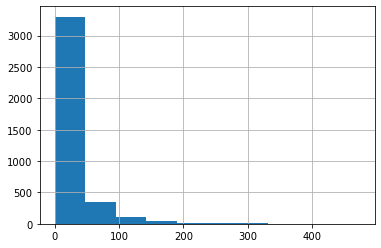


review_scores_rating


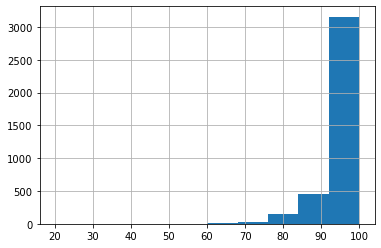


review_scores_accuracy


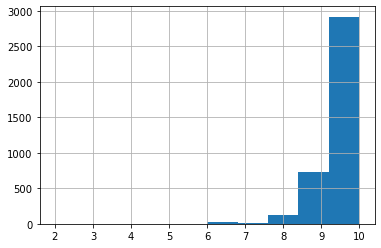


review_scores_cleanliness


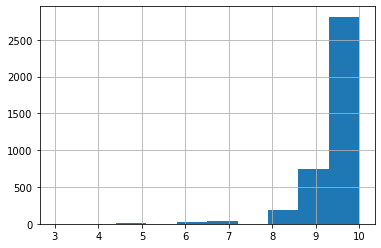


review_scores_checkin


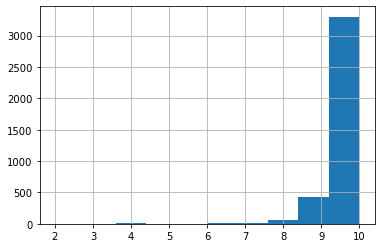


review_scores_communication


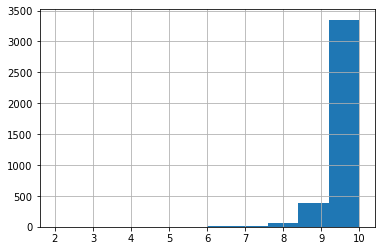


review_scores_location


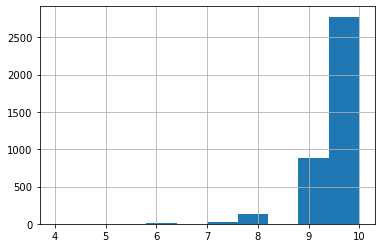


review_scores_value


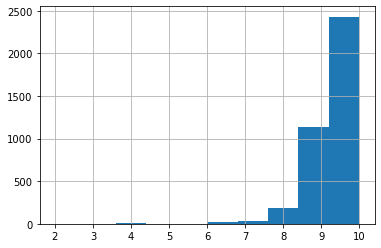


requires_license


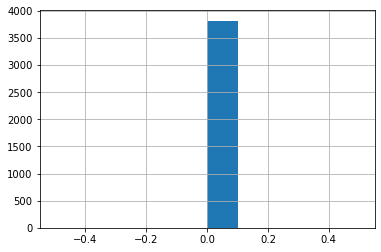


instant_bookable


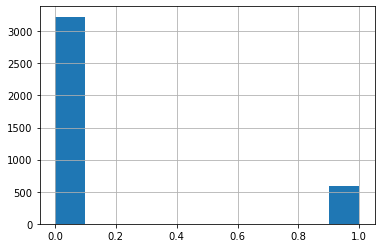


require_guest_profile_picture


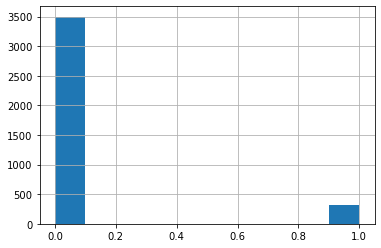


require_guest_phone_verification


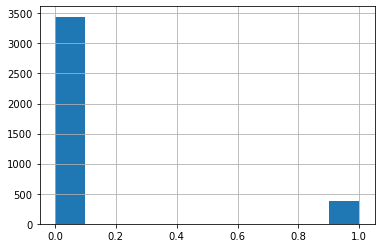


calculated_host_listings_count


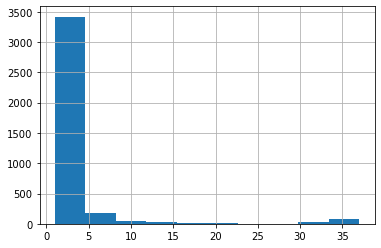


reviews_per_month


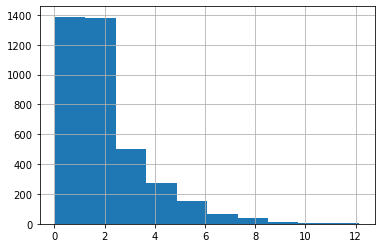


revenue


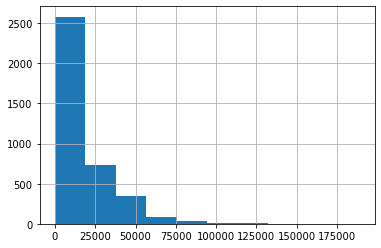


host_response_time_within a day


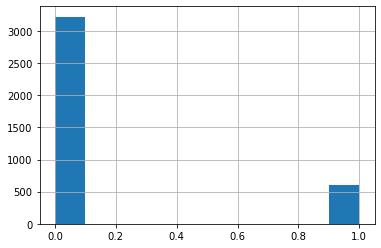


host_response_time_within a few hours


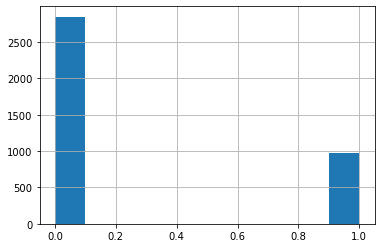


host_response_time_within an hour


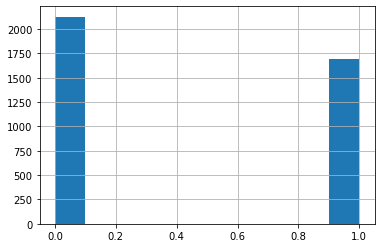


zipcode_98102


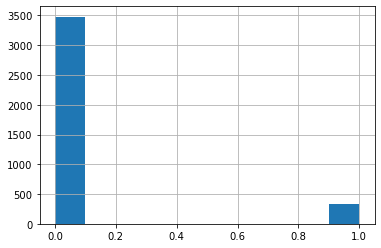


zipcode_98103


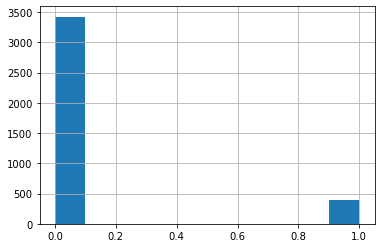


zipcode_98104


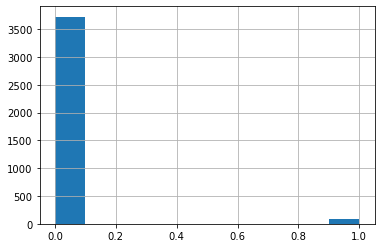


zipcode_98105


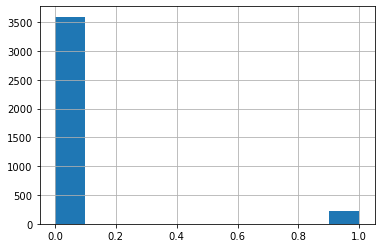


zipcode_98106


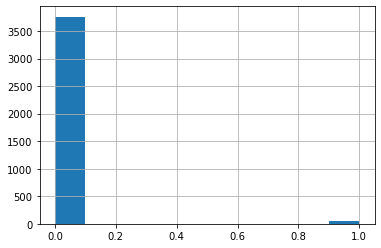


zipcode_98107


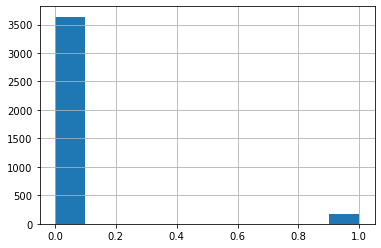


zipcode_98108


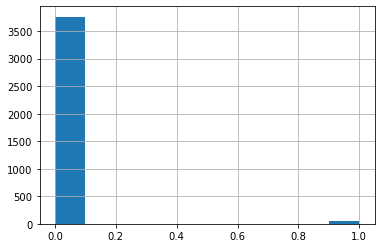


zipcode_98109


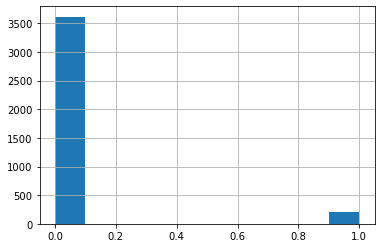


zipcode_98112


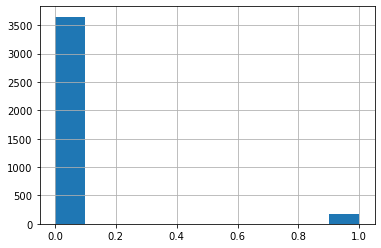


zipcode_98115


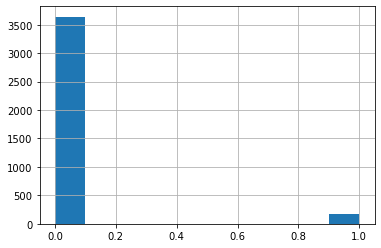


zipcode_98116


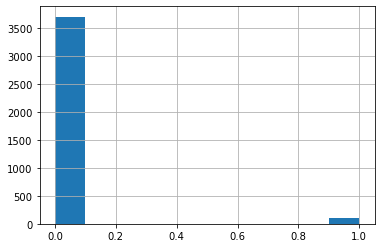


zipcode_98117


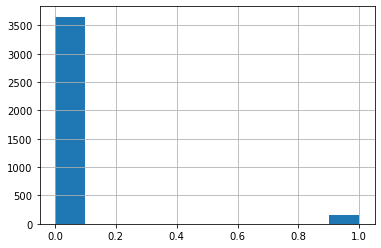


zipcode_98118


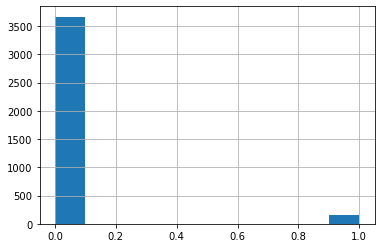


zipcode_98119


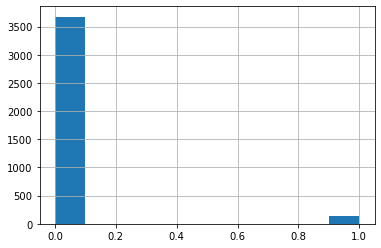


zipcode_98121


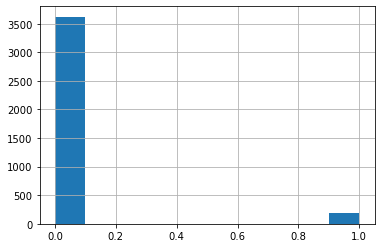


zipcode_98122


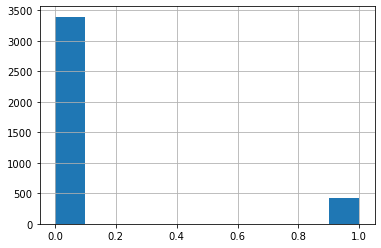


zipcode_98125


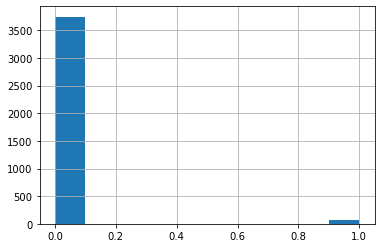


zipcode_98126


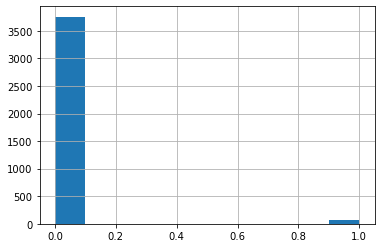


zipcode_98133


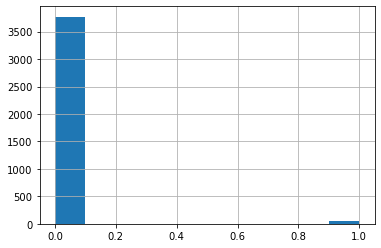


zipcode_98134


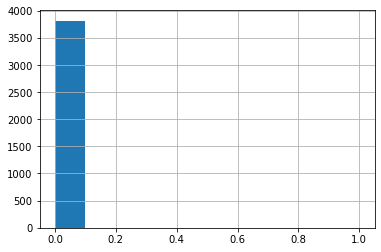


zipcode_98136


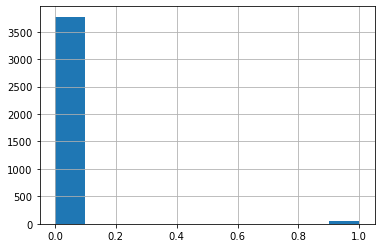


zipcode_98144


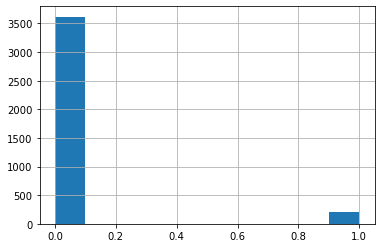


zipcode_98146


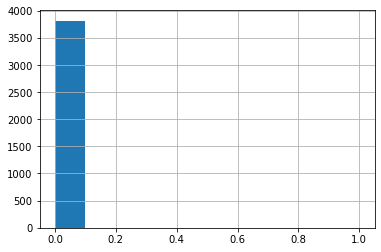


zipcode_98177


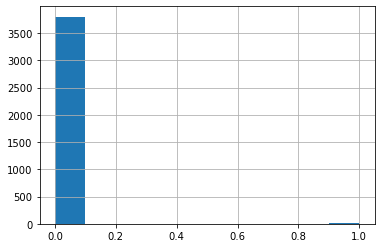


zipcode_98178


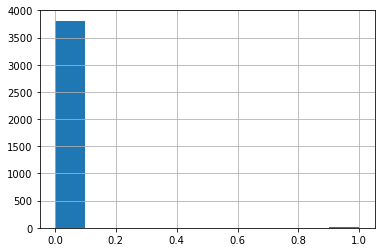


zipcode_98199


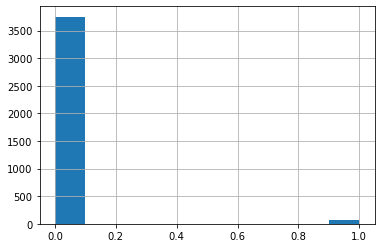


zipcode_99
98122


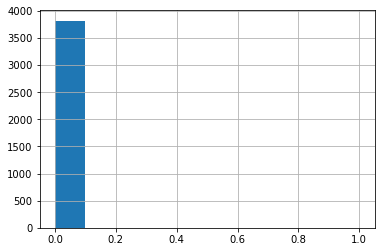


property_type_Bed & Breakfast


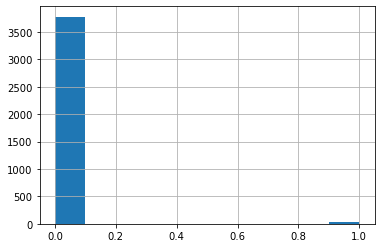


property_type_Boat


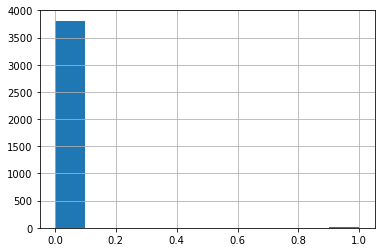


property_type_Bungalow


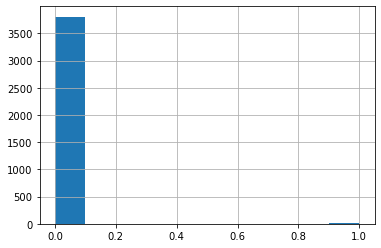


property_type_Cabin


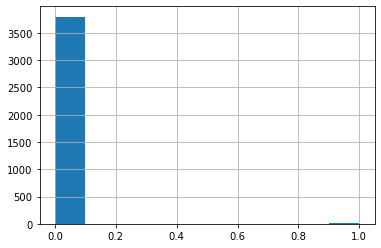


property_type_Camper/RV


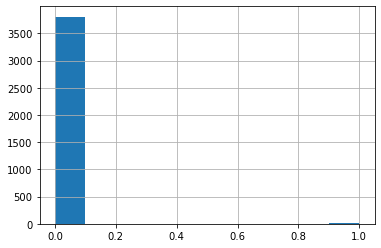


property_type_Chalet


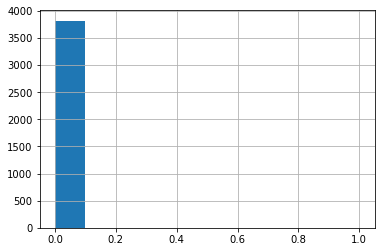


property_type_Condominium


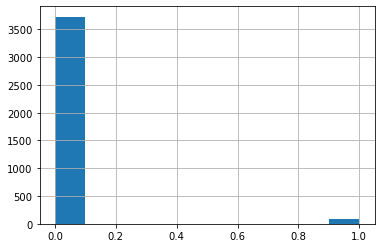


property_type_Dorm


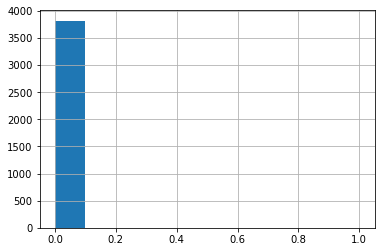


property_type_House


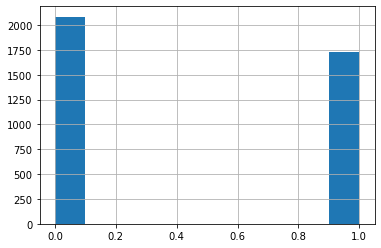


property_type_Loft


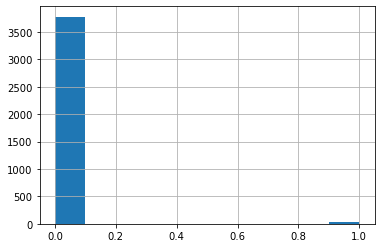


property_type_Other


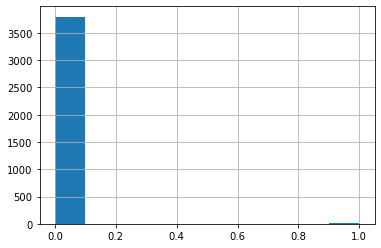


property_type_Tent


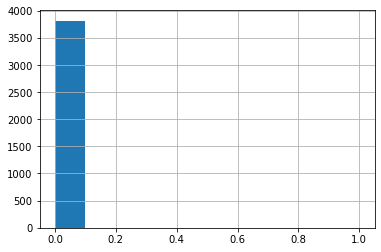


property_type_Townhouse


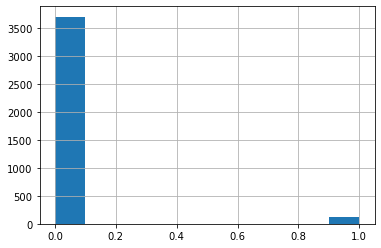


property_type_Treehouse


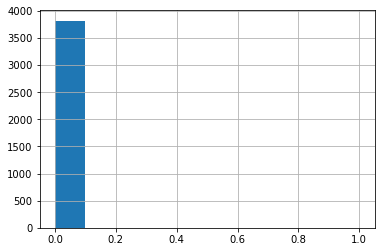


property_type_Yurt


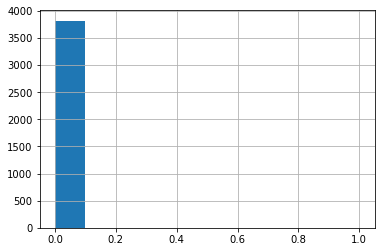


room_type_Private room


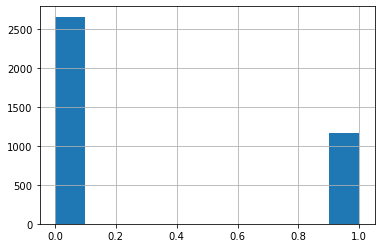


room_type_Shared room


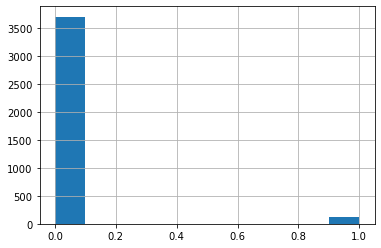


bed_type_Couch


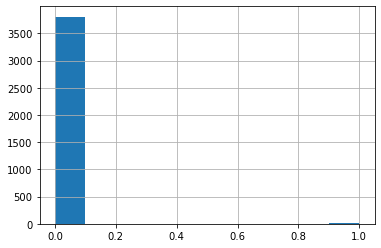


bed_type_Futon


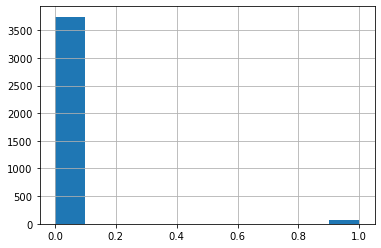


bed_type_Pull-out Sofa


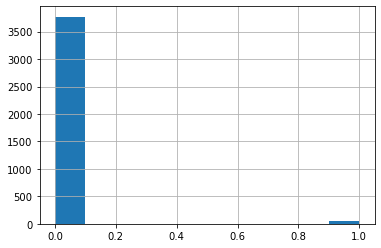


bed_type_Real Bed


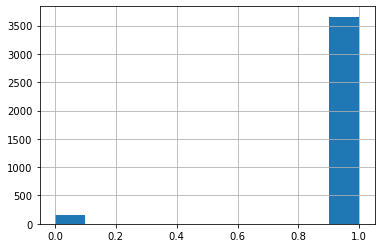


cancellation_policy_moderate


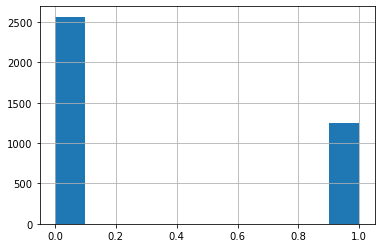


cancellation_policy_strict


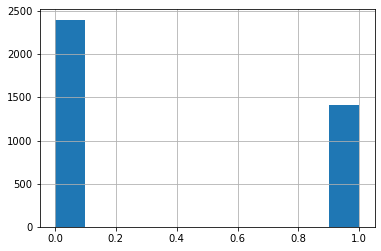


TV


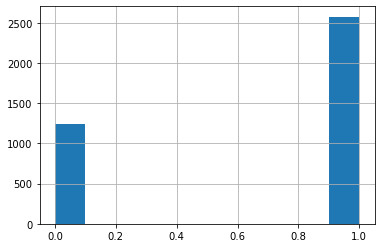


Cable TV


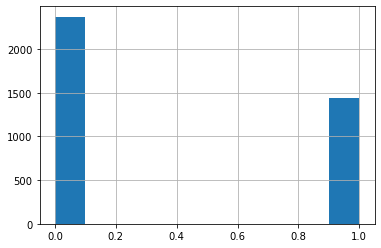


Internet


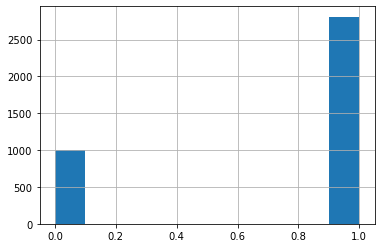


Wireless Internet


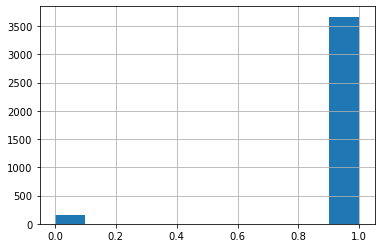


Air Conditioning


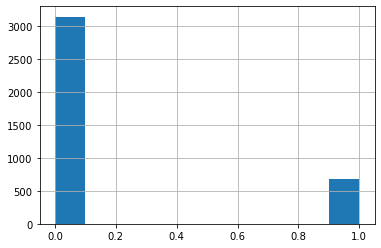


Kitchen


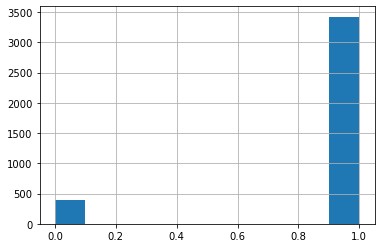


Heating


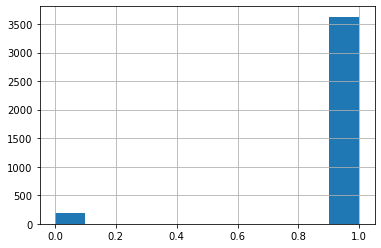


Family/Kid Friendly


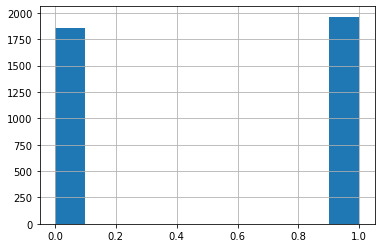


Washer


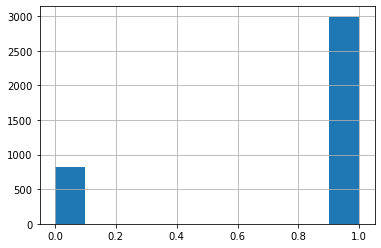


Dryer


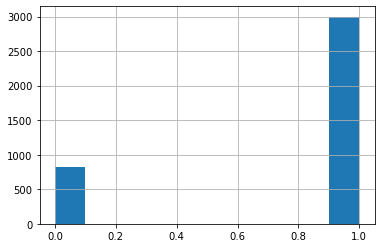


Free Parking on Premises


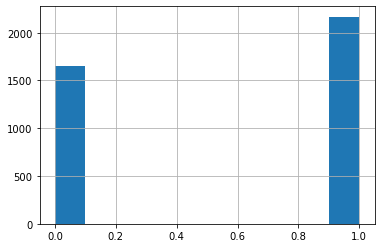


Buzzer/Wireless Intercom


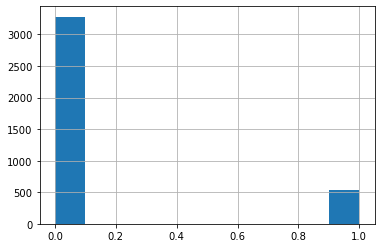


Smoke Detector


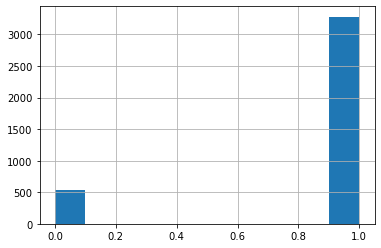


Carbon Monoxide Detector


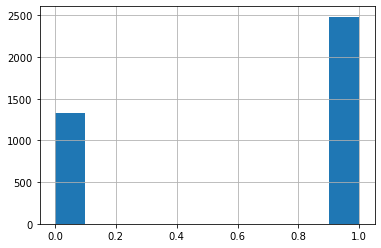


First Aid Kit


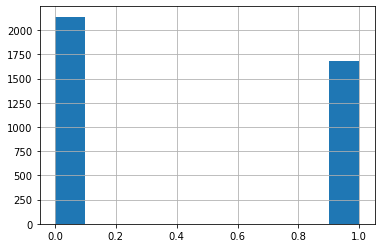


Safety Card


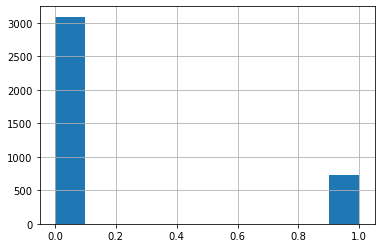


Fire Extinguisher


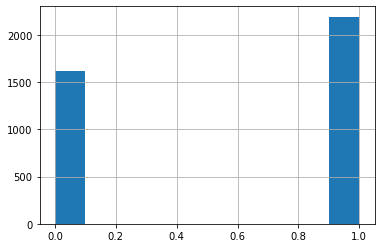


Essentials


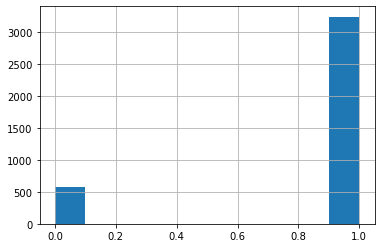


Pets Allowed


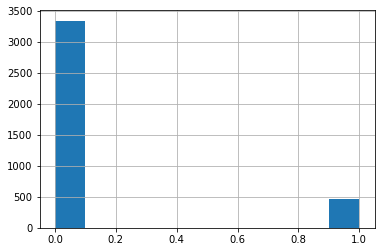


Pets live on this property


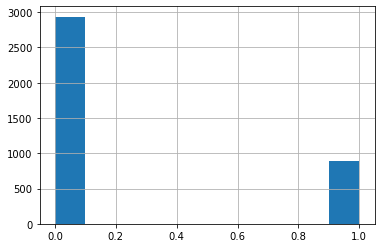


Dog(s)


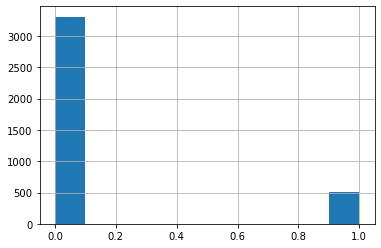


Cat(s)


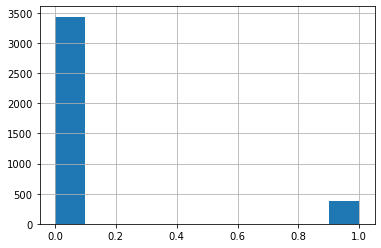


Hot Tub


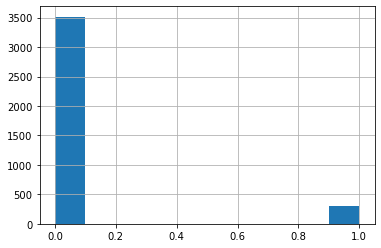


Indoor Fireplace


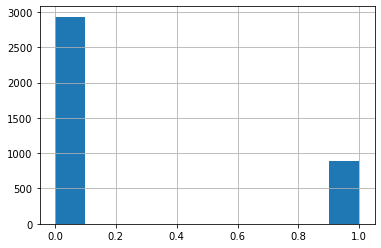


Shampoo


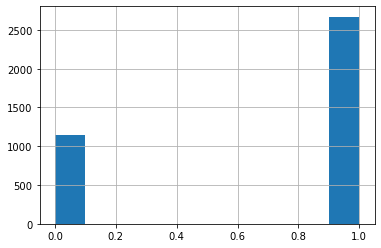


Breakfast


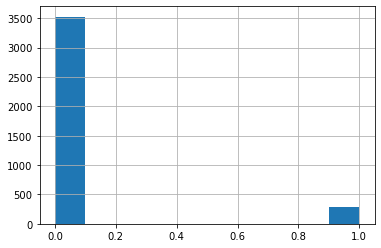


24-Hour Check-in


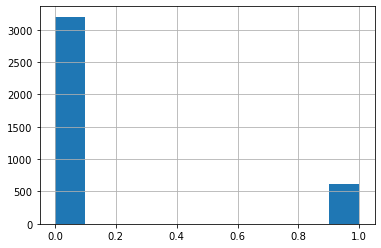


Hangers


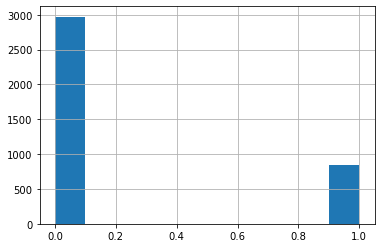


Hair Dryer


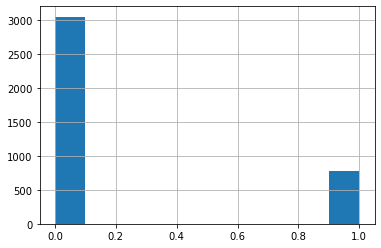


Iron


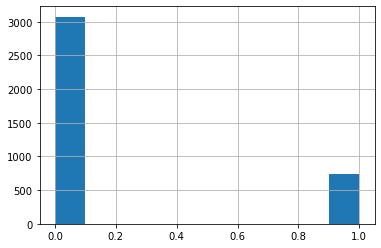


Laptop Friendly Workspace


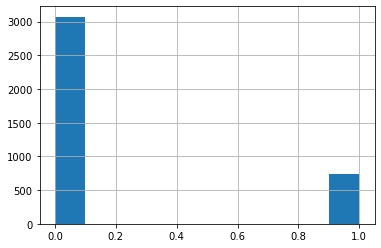


Suitable for Events


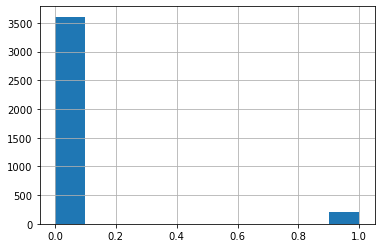


Elevator in Building


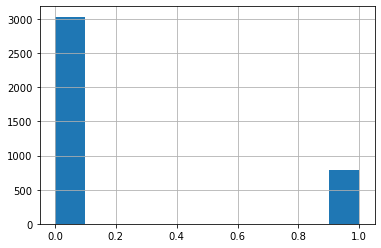


Lock on Bedroom Door


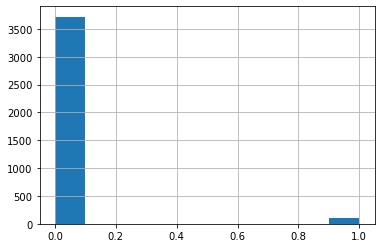


Wheelchair Accessible


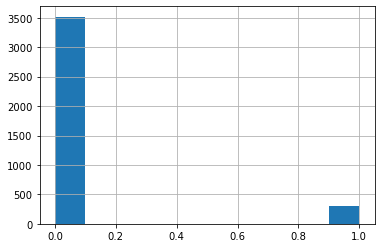


Gym


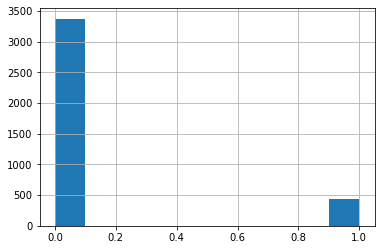


Pool


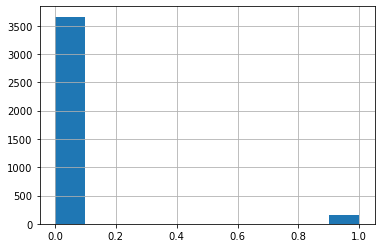


Smoking Allowed


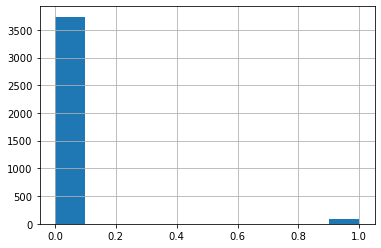


Other pet(s)


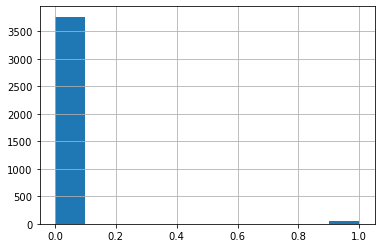


Doorman


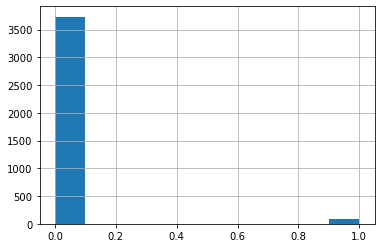


Washer / Dryer


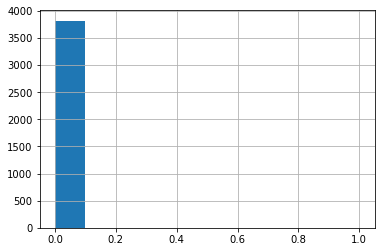


email


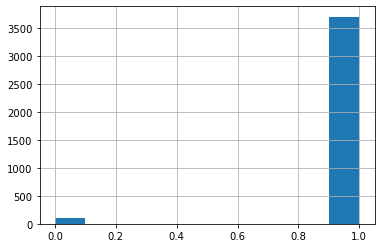


 phone


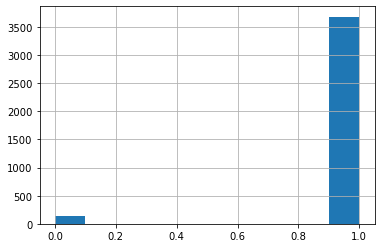


 reviews


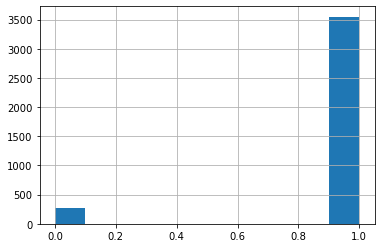


 kba


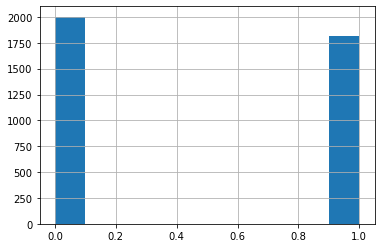


 facebook


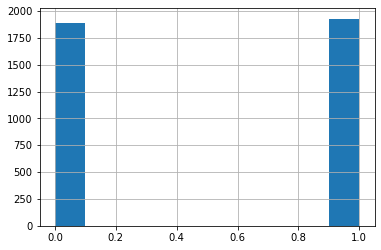


 linkedin


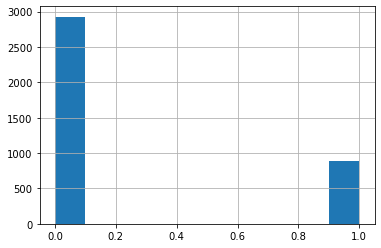


 jumio


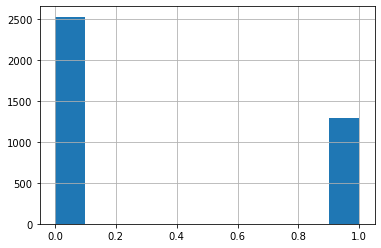


 google


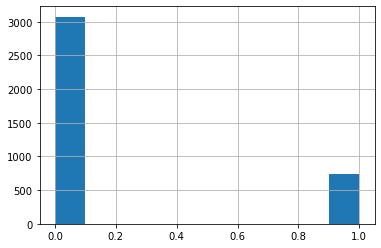


phone


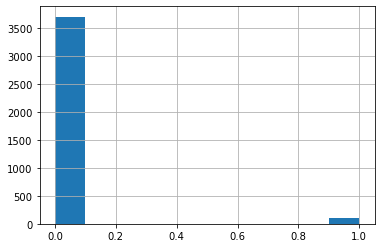


 manual_offline


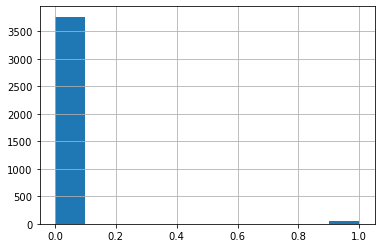


 amex


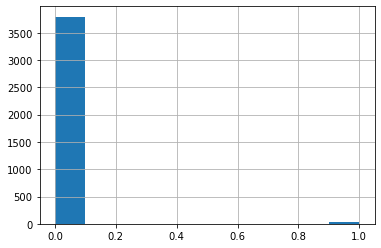


 manual_online


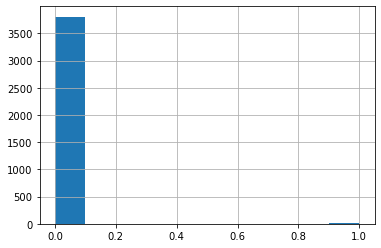


 sent_id


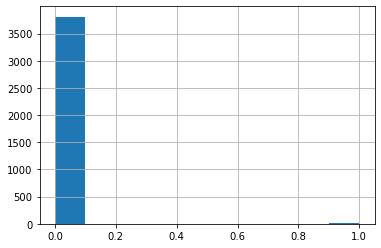


 photographer


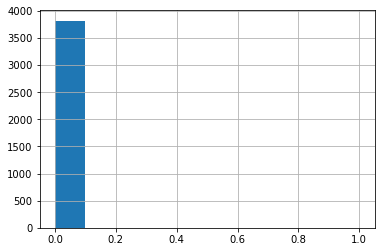


None


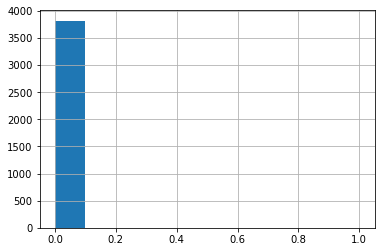


 weibo


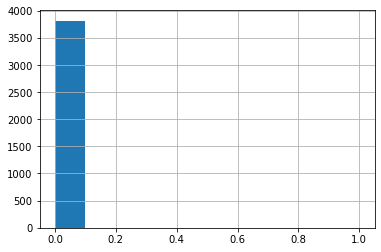


google


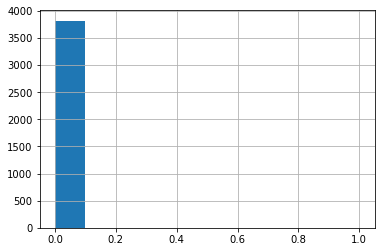


reviews


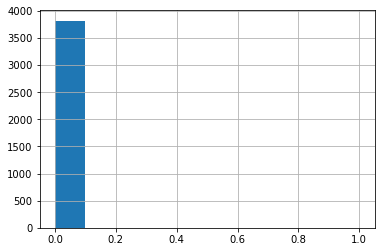

In [831]:
#Manual check of askewness; looking for all zeros or all ones
for c in df_5.columns:
    print(c)
    df_5[c].hist().plot();
    plt.show()
    input()     
    

In [832]:
#from above we can remove the following columns
df_6=df_5.drop(columns=['requires_license','None','id'])

In [833]:
#We try to predict revenue considering all features overall. What maximizes revenue?
y=df_6['revenue']
X=df_6.drop(columns=['revenue'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Modeling - Linear Regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
scale= MinMaxScaler()

X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train) 

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
l1 = mean_absolute_error(y_train, y_train_pred)
l2 = mean_absolute_error(y_test, y_test_pred)
# Print model evaluation scores for training and test
print('Traning Data:')
print('r-squared score: %.3f' % r2_score(y_train, y_train_pred))
print('Mean absolute error: %.3f' % l1)
print('------------------------------')
print('Test Data:')
print('r-squared score: %.3f' % r2_score(y_test, y_test_pred))
print('Mean absolute error: %.3f' % l2)
print('------------------------------')


Traning Data:
r-squared score: 0.310
Mean absolute error: 12717.253
------------------------------
Test Data:
r-squared score: 0.261
Mean absolute error: 13576.313
------------------------------


In [835]:
def coef_weights(coefficients, X):
    coefs_df = pd.DataFrame()
    coefs_df['Features'] = X.columns
    coefs_df['coefs'] = model.coef_
    coefs_df = coefs_df.sort_values('coefs', ascending=False)
    return coefs_df

coef_df = coef_weights(model.coef_,X)
coef_df.head(20)

,Features,coefs
4,host_total_listings_count,6.142717e+16
12,price,5.731075e+04
10,bedrooms,3.359300e+04
124,email,2.156050e+04
73,property_type_Treehouse,1.659944e+04
135,manual_online,1.289819e+04
132,phone,1.134669e+04
1,host_response_rate,1.097372e+04
92,Dryer,6.858000e+03
74,property_type_Yurt,6.432219e+03


### Evaluation and Discussion Part 3: In Seattle, which factors overall are good for revenue?
After the fitting the linear regressor, we were able to get the dominant features that predict revenue in Seattle. As expected, factors such as price, number of bedrooms, the host's total listing count are good predictors of revenue. Furthermore, host reponse rate, treehouses and verification methods such as email, phone and manual_online seem to work well in Seattle. In terms of amenities, dryer seems to stand out.

The performance of the linear regressor is subpar. While we are certain that it did not overfit due to close r2 values for both the training set and testing ret, the r2 values themselves show a poor fit. A poor fit that, nonetheless, helped us look at this Seattle dataset in a new light. 

A future recommendation would be to use an AdaBoostRegressor with this fitted linear regressor as a weak learner. This should significantly improve the fit. However, we should still be wary of overfitting with a more aggressive approach.
